This notebook presents all the analysis reported in Study 2 of the paper.

Click the "Show Code" buttons to see the code associated with each output.

# Preamble

## Libraries

In [1]:
# Misc
import warnings

warnings.filterwarnings("ignore")
from IPython.display import Markdown

# Data libraries
import pandas as pd
import numpy as np

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")

# Statistics
import statsmodels.formula.api as smf
import scipy.stats as stats
from scipy.stats.mstats import zscore

# Interface with R
import rpy2

%load_ext rpy2.ipython
%R library(sjstats); # For effect sizes of ANOVAs

STUDY_NAME = "Study 2"

## Functions

In [2]:
def planned_contrasts(contrasts, names, model, use_t=False, alpha=0.05):
    """
    Convenience functions for planned contrasts from a model.
    """
    betas = model.params.values
    vcv = model.cov_params().values
    b = []
    se = []
    for c in contrasts:
        b.append(betas @ c)
        se.append(c @ vcv @ c)
    b = np.array(b)
    se = np.sqrt(se)
    z = b / se
    if use_t:
        df_resid = model.df_resid
        pvals = stats.t(df_resid).sf(np.abs(z)) * 2
        ci_factor = stats.t(df_resid).isf(alpha / 2)
        name_coeff = "t-stats"
    else:
        pvals = stats.norm.sf(np.abs(z)) * 2
        ci_factor = stats.norm.isf(alpha / 2)
        name_coeff = "z-stats"
    llci, ulci = b - se * ci_factor, b + se * ci_factor
    bstd = b / model.model.endog.std(ddof=1)
    df_contrasts = pd.DataFrame(
        {
            "Contrast": names,
            "Beta": b,
            "SE": se,
            name_coeff: z,
            "p-value": pvals,
            "LLCI": llci,
            "ULCI": ulci,
            "Standardized B": bstd,
        }
    )
    return df_contrasts


def plot_result(
    data, save=False, show=True, grayscale=False, figname=f"Fig 4 - {STUDY_NAME} - Results"
):
    if grayscale:
        pal = sns.color_palette("Greys")[1::2]
        pathname = "Grayscale"
    else:
        pal = sns.color_palette("coolwarm", 3)
        pathname = "Color"

    if show:
        sns.set_context("notebook")
    else:
        sns.set_context("paper")

    g = sns.catplot(
        x="is_manipulated",
        hue="sd_manipulated",
        hue_order=["Low", "Med", "High"],
        y="value_sd",
        data=data,
        kind="bar",
        aspect=1.5,
        height=6.38 / 1.5,
        order=[True, False],
        sharey=False,
        sharex=False,
        legend_out=False,
        palette=pal,
    )

    g.set_titles("")
    g.set_xlabels("")
    leg = g.ax.legend()

    han = leg.legendHandles
    leg.remove()

    g.ax.legend(
        han,
        ["Low (SD = 1.1)", "Med (SD = 4.5)", "High (SD = 7.5)"],
        title="SD of Manipulated Category",
        loc="upper center",
        bbox_to_anchor=(0.75, 1.03),
        frameon=False,
    )
    g.ax.set_ylim(2, 8)
    g.ax.set_xticklabels(["Manipulated Category", "Common Category (SD = 4.5)"])
    g.ax.set_ylabel("SD of Reported Prices")
    for ax in g.axes.flatten():
        ax.tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=True
        )
    plt.tight_layout()
    if save:
        plt.savefig(
            f"../Figures/{pathname}/{figname}.png", dpi=100, bbox_inches="tight"
        )
    if show:
        plt.show()
    else:
        plt.close()

## Data loading and preparation

In [3]:
df = (
    pd.read_csv(f"../Data/{STUDY_NAME}/LongData.csv")
    .groupby(
        [
            "turkid",
            "name",
            "name_manipulated",
            "is_manipulated",
            "sd_manipulated",
            "avg_learning_time",
            "total_learning_time",
        ]
    )
    .value.agg(
        **{
            "value_sd": np.std,
            "value_range": lambda x: np.max(x) - np.min(x),
            "value_min": np.min,
            "value_max": np.max,
            "value_mean": np.mean,
            "value_var": lambda x: np.std(x) ** 2,
        }
    )
    .reset_index()
)

# Design

## Characteristics and distributions

Replication of study 1: Each participant sees two distributions, one "manipulated", one "common".
* The "common" distribution always has a "Medium" amount of variance (SD = 4.5, Min = 17, Max = 34)
* The "manipulated" distribution has a different variance, between subjects:
    * "Low" (SD = 1.1, Min = 23, Max = 28)
    * "Medium" (SD = 4.5, Min = 17, Max = 34)
    * "High" (SD = 7.5, Min = 13, Max = 38)

This time however, the two categories were Blankets and Pillows, and participants were able to click through the prices at their own pace.

## Number of valid participants:

In [4]:
df.turkid.unique().shape[0]

296

# Analysis

## Time spent on prices

In the previous studies, the participants could only view each price for one second, and therefore spent 52 seconds in total learning the prices. 

How long did they linger on the prices in this study?

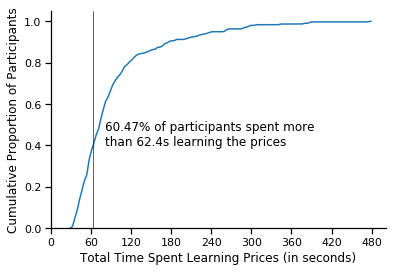

In [5]:
ax = sns.kdeplot(df.total_learning_time, cumulative=True, legend=False, bw=1)
ax.set_xlabel("Total Time Spent Learning Prices (in seconds)")
ax.set_ylabel("Cumulative Proportion of Participants")
ax.axvline(62.4, color="black", lw=0.6)
ax.set_xticks(np.arange(0, 500, 60))
propgreater = (df.total_learning_time > 62.4).mean() * 100
ax.annotate(
    f"{propgreater:.2f}% of participants spent more\nthan 62.4s learning the prices",
    (80, 0.4),
)
sns.despine(ax=ax);

Participants spent on average of 91.57s reviewing the prices, which correspond to an average of 1.79s spent learning each price. 

The majority of participants (60.47%) spent more time on the price than the time that was allocated in study 1 (62.4s).

## Perceived dispersion

### SD

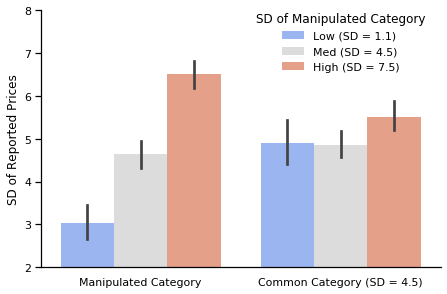

In [6]:
plot_result(df, grayscale=True, save=True, show=False)
plot_result(df, grayscale=False, save=True, show=True)
table = (
    df.groupby(["is_manipulated", "sd_manipulated"])[["value_sd"]]
    .mean()
    .reindex(
        labels=[
            [False, False, False, True, True, True],
            ["Low", "Med", "High", "Low", "Med", "High"],
        ]
    )
)
table.index.names = ["Manipulated?", "SD of Manipulated"]
table.columns = ["SD"]
table.style.format("{:.2f}")

In [7]:
6.51/4.75

1.3705263157894736

In [8]:
model = smf.mixedlm(
    "value_sd ~ C(sd_manipulated, levels=['Med', 'Low', 'High'])\
*C(is_manipulated, Treatment(0))",
    data=df,
    groups=df.turkid,
).fit()
model.summary(
    yname="SD of Reported Distribution",
    xname_fe=[
        "Intercept",
        "Dispersion: Low (vs. Medium)",
        "Dispersion: High (vs. Medium)",
        "Target: Manipulated (vs. Common)",
        "Dispersion: Low * Target",
        "Dispersion: High * Target",
    ],
    xname_re=["Participants Random Effects"],
)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
===========================================================================
Model:              MixedLM Dependent Variable: SD of Reported Distribution
No. Observations:   592     Method:             REML                       
No. Groups:         296     Scale:              2.0855                     
Min. group size:    2       Log-Likelihood:     -1194.8286                 
Max. group size:    2       Converged:          Yes                        
Mean group size:    2.0                                                    
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                         4.869    0.191 25.488 0.000  4.494  5.243
Dispersion: Low (vs. Medium)      0.035    0.272  0.129 0.897 -0.497  0.567
Dispersion: High (vs. Medium)     0.650    0.272  2.392 0.017  0.117  1.182
Target: Manipulated (vs. Common) -0.221    0.204 -1.084 0.278 -0.622  0.179
Dispersion: Low * Target         -1.655    0.290 -5.701 0.000 -2.224 -1.086
Dispersion: High * Target         1.211    0.290  4.170 0.000  0.642  1.780
Participants Random Effects       1.563    0.211                           
===========================================================================

"""

Standardized betas:

In [9]:
stdbetas = model.params / df.value_sd.std(ddof=1)
stdbetas.index = [
    "Intercept",
    "Dispersion: Low (vs. Medium)",
    "Dispersion: High (vs. Medium)",
    "Target: Manipulated (vs. Common)",
    "Dispersion: Low * Target",
    "Dispersion: High * Target",
    "Participants Random Effects",
]
table = pd.DataFrame(stdbetas, columns=["Standardized Betas"])
table.style.format("{:.2f}")

,Standardized Betas
Intercept,2.25
Dispersion: Low (vs. Medium),0.02
Dispersion: High (vs. Medium),0.30
Target: Manipulated (vs. Common),-0.10
Dispersion: Low * Target,-0.76
Dispersion: High * Target,0.56
Participants Random Effects,0.35


In [10]:
.30/.86

0.3488372093023256

In [11]:
Markdown(
    f"""
A mixed linear model with category type (common vs. manipulated) as a within-participant factor 
and the actual price dispersion of the manipulated category (low vs. medium vs. high) as a between-participant 
factor replicated the assimilation effect documented in study 1. 

Indeed, participants created a wider distribution 
for the common category when the manipulated category had a high (vs. medium) amount of dispersion: 
b = {model.params[2]:.3f}, z = {model.tvalues[2]:.3f}, p = {model.pvalues[2]:.3f}, standardized b = {stdbetas[2]:.3f}). 


However, they did not report a lower amount of dispersion for the common category when the manipulated distribution 
had a low (vs. medium) amount of dispersion: 
b = {model.params[1]:.3f}, z = {model.tvalues[1]:.3f}, p = {model.pvalues[1]:.3f}. 
This result also replicates the asymmetry that we had documented in study 1.
"""
)


A mixed linear model with category type (common vs. manipulated) as a within-participant factor 
and the actual price dispersion of the manipulated category (low vs. medium vs. high) as a between-participant 
factor replicated the assimilation effect documented in study 1. 

Indeed, participants created a wider distribution 
for the common category when the manipulated category had a high (vs. medium) amount of dispersion: 
b = 0.650, z = 2.392, p = 0.017, standardized b = 0.300). 


However, they did not report a lower amount of dispersion for the common category when the manipulated distribution 
had a low (vs. medium) amount of dispersion: 
b = 0.035, z = 0.129, p = 0.897. 
This result also replicates the asymmetry that we had documented in study 1.


### Range

In [12]:
model = smf.mixedlm(
    "value_range ~ C(sd_manipulated, levels=['Med', 'Low', 'High'])\
*C(is_manipulated, Treatment(0))",
    data=df,
    groups=df.turkid,
).fit()
model.summary(
    yname="Range of Reported Distribution",
    xname_fe=[
        "Intercept",
        "Dispersion: Low (vs. Medium)",
        "Dispersion: High (vs. Medium)",
        "Target: Manipulated (vs. Common)",
        "Dispersion: Low * Target",
        "Dispersion: High * Target",
    ],
    xname_re=["Participants Random Effects"],
)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:            MixedLM Dependent Variable: Range of Reported Distribution
No. Observations: 592     Method:             REML                          
No. Groups:       296     Scale:              18.7638                       
Min. group size:  2       Log-Likelihood:     -1846.5679                    
Max. group size:  2       Converged:          Yes                           
Mean group size:  2.0                                                       
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         16.720    0.584 28.610 0.000 15.575 17.865
Dispersion: Low (vs. Medium)       0.137    0.831  0.165 0.869 -1.491  1.765
Dispersion: High (vs. Medium)      2.607    0.831  3.138 0.002  0.978  4.235
Target: Manipulated (vs. Common)  -0.320    0.613 -0.522 0.601 -1.521  0.881
Dispersion: Low * Target          -5.700    0.871 -6.547 0.000 -7.407 -3.994
Dispersion: High * Target          3.300    0.871  3.789 0.000  1.593  5.006
Participants Random Effects       15.390    0.668                           
============================================================================

"""

Standardized betas:

In [13]:
stdbetas = model.params / df.value_range.std(ddof=1)
stdbetas.index = [
    "Intercept",
    "Dispersion: Low (vs. Medium)",
    "Dispersion: High (vs. Medium)",
    "Target: Manipulated (vs. Common)",
    "Dispersion: Low * Target",
    "Dispersion: High * Target",
    "Participants Random Effects",
]
table = pd.DataFrame(stdbetas, columns=["Standardized Betas"])
table.style.format("{:.2f}")

,Standardized Betas
Intercept,2.47
Dispersion: Low (vs. Medium),0.02
Dispersion: High (vs. Medium),0.39
Target: Manipulated (vs. Common),-0.05
Dispersion: Low * Target,-0.84
Dispersion: High * Target,0.49
Participants Random Effects,0.12


# Robustness Checks

## Counterbalancing factor - SD

In [14]:
model = smf.mixedlm(
    "value_sd ~ C(sd_manipulated, levels=['Med', 'Low', 'High'])\
*C(is_manipulated)*C(name_manipulated, Sum)",
    data=df,
    groups=df.turkid,
).fit()
model.summary(
    yname="SD of Reported Distribution",
    xname_fe=[
        "Intercept",
        "Dispersion: Low (vs. Medium)",
        "Dispersion: High (vs. Medium)",
        "Target: Manipulated (vs. Common)",
        "Counterbalancing Factor (CF)",
        "Dispersion: Low * Target",
        "Dispersion: High * Target",
        "Dispersion: Low * CF",
        "Dispersion: High * CF",
        "Target * CF",
        "Dispersion: Low * Target * CF",
        "Dispersion: High * Target * CF",
    ],
)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
===========================================================================
Model:              MixedLM Dependent Variable: SD of Reported Distribution
No. Observations:   592     Method:             REML                       
No. Groups:         296     Scale:              2.0888                     
Min. group size:    2       Log-Likelihood:     -1197.6829                 
Max. group size:    2       Converged:          Yes                        
Mean group size:    2.0                                                    
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                         4.872    0.192 25.434 0.000  4.496  5.247
Dispersion: Low (vs. Medium)      0.033    0.272  0.120 0.904 -0.501  0.567
Dispersion: High (vs. Medium)     0.651    0.272  2.389 0.017  0.117  1.184
Target: Manipulated (vs. Common) -0.227    0.204 -1.112 0.266 -0.628  0.173
Counterbalancing Factor (CF)      0.151    0.192  0.791 0.429 -0.224  0.527
Dispersion: Low * Target         -1.650    0.291 -5.675 0.000 -2.219 -1.080
Dispersion: High * Target         1.222    0.291  4.205 0.000  0.653  1.792
Dispersion: Low * CF             -0.168    0.272 -0.617 0.537 -0.702  0.366
Dispersion: High * CF            -0.251    0.272 -0.922 0.357 -0.785  0.283
Target * CF                      -0.293    0.204 -1.433 0.152 -0.694  0.108
Dispersion: Low * Target * CF     0.307    0.291  1.056 0.291 -0.263  0.877
Dispersion: High * Target * CF    0.150    0.291  0.517 0.605 -0.419  0.720
Group Var                         1.579    0.213                           
===========================================================================

"""

No significant impact.